# Initialize

In [1]:
import os
init=False

# Imports

In [2]:
if not init:
    os.chdir('..')
    init=True
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from scipy.linalg import subspace_angles, null_space, orth

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

from typing import Optional

# Get Data

In [3]:
dp = DataPartitioner(session='Moe46',
                    areas=['M1','F5','AIP'],
                    aligns=['fixation','cue onset','go cue onset','movement onset','hold onset'],
                    contexts=['active','passive','control'],
                    groupings=['context','alignment','grip','object','turntable','time'])

# TODO: [x] try go cue onset as the alignment for the "visual" space (i.e., include memory signals, *really* make sure you're isolating those transients!) ([...] also include context & turntable as separable factors in the space you try to remove, and use a 95% variance criterion like the one used in the paper instead of these weak classification criteria)
# TODO: visualize the time-varying nature of the signals before & after removal... *somehow* (save this for after NCM)
# TODO: [x] active vs. passive cross-classification of OBJECT, before & after subspace removal

In [4]:
# query the whole damn thing
df = dp.readQuery(0)

# convert from turntable x object ID vs. just the turntable ID
df['turntable'] = df['turntable'] // 10

# Find the size of the subspace that object vision occupies

In [5]:
df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
labels             = df_vision_trials.index.get_level_values(0)

# Note: cross-decoding is simply too conservative.
# It preserves classification of the special turntables, for instance
# Instead, just abolish the entire space that leads to supra-chance visual classification, period

flag          = False
axesToRemove  = 0
neurcount     = len(dp.get('neuronColumnNames'))
pccount       = 30
nsplits       = 5

skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
splits  = skf.split(np.zeros(len(labels)),labels)
splits  = list(splits) # store as list to allow it to be used many of time
PCmdls  = []
deltamu = []

# step 1: find the set of axes for each split
for train_,_ in splits:
    df_vision_agg = df_vision_trials.iloc[train_].groupby(level=[0]).aggregate('mean')
    n_components = min(df_vision_agg.shape) - 1
    PCmdl = PCA(n_components=n_components)
    PCmdl.fit(df_vision_agg.to_numpy())
    PCmdls+=[PCmdl]
    
    # no delta-mus needed

# step 2: iterate model fitting
maxAxesToRemove = PCmdls[0].n_components_
while not flag:
    correct_count = 0
    chance_count  = 0
    total_count   = len(labels)
    
    for fold,(train_,test_) in enumerate(splits):
        trainX = df_vision_trials.iloc[train_]
        trainy = labels[train_].to_numpy()
        
        testX  = df_vision_trials.iloc[test_]
        testy  = labels[test_].to_numpy()
        
        if axesToRemove > 0:
            nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
        else:
            nullSpace = np.eye(neurcount)
            
        # projections
        trainX = trainX.to_numpy() @ nullSpace
        testX  = testX.to_numpy() @ nullSpace
        
        # no deltamu to get rid of
        
        # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
        PCmdl = PCA(n_components=pccount)
        trainX = PCmdl.fit_transform(trainX)
        testX  = PCmdl.transform(testX)
        
        # now we can finally start classifying!
        LDmdl = LDA()
        LDmdl.fit(trainX,trainy)
        yhat = LDmdl.predict(testX)
        
        correct_count += np.sum(yhat==testy)
        chance_count  += len(testy) * max(LDmdl.priors_)
        
    correct_rate   = correct_count / total_count
    chance_rate    = chance_count / total_count
    threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE
    
    print(f"Removed axes = {axesToRemove}")
    print(f"Accuracy = {correct_rate}")
    print(f"Chance = {chance_rate}")
    print(f"Threshold = {threshold_rate}")
    print()
    
    if correct_rate > threshold_rate and axesToRemove<maxAxesToRemove:
        axesToRemove+=1
    else:
        flag = True
        
print(f"Final result: remove {axesToRemove} axes")
# axesToRemove = maxAxesToRemove  # forget it, remove everything (doesn't actually help much)
# note: baseline effects in terms of turntable x context exist
# however, we only ever classify within context, and even when we cross-classify, we remove the mean-separating subspace
# moreover, to the extent these baseline effects persist through cue onset, these turntable effects should be, for the most part, a subset of the overall object effect (with the exception of the mixed turntable, which repeats some objects from the other turntables and thus has a turntable effect not accounted for by object ID alone)

Removed axes = 0
Accuracy = 0.4845679012345679
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 1
Accuracy = 0.4228395061728395
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 2
Accuracy = 0.3117283950617284
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 3
Accuracy = 0.26697530864197533
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 4
Accuracy = 0.20987654320987653
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 5
Accuracy = 0.16358024691358025
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 6
Accuracy = 0.1558641975308642
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 7
Accuracy = 0.13117283950617284
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 8
Accuracy = 0.11265432098765432
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes =

# Alternate method: PCA
- question: do we explicitly try to find dimensions that don't affect grip decoding? 
- Maybe later if things still aren't working or we want to test if we can bump passive performance after all

36 components to hit 95% variance explained prior to movement preparation


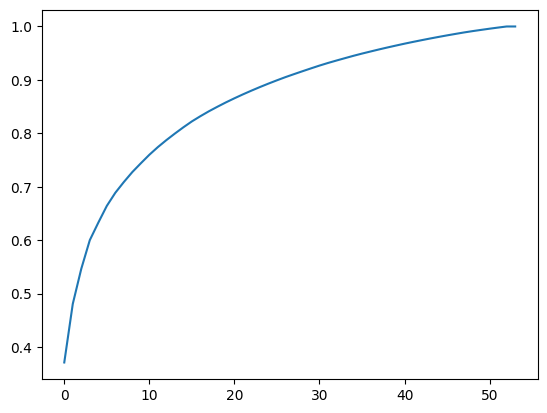

In [6]:
df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

PCmdl    = PCA()
PCmdl.fit(df_vision_trials.to_numpy())
cumscree = np.cumsum(PCmdl.explained_variance_ratio_)

idx  = 0
while (cumscree[idx]<0.95):
    idx+=1

# axesToRemove = idx
print(f"{idx} components to hit 95% variance explained prior to movement preparation")

plt.plot(cumscree)

# Here be controls:
1. Vision-Grasping cross-decoding is abolished
2. Special turntable stops being decoded during movement
3. grasping box keeps being decoded during movement
4. "control" task performance during movement is less affected than "active" task

## Vision-Grasping cross-decoding

In [7]:
# vision-grasping cross-decoding
df_vision_trials   = df[(df['alignment']=='go cue onset') & (df['time']<0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
labels             = df_vision_trials.index.get_level_values(0) # should be equal between 
labels_            = df_movement_trials.index.get_level_values(0)
assert ((df_vision_trials.shape[0]>0) & (df_movement_trials.shape[0]>0)), "no trials match test criteria"
assert np.all(labels==labels_), "labels are not equal"

flag          = False
# axesToRemove  = 0 # don't undo this!
neurcount     = len(dp.get('neuronColumnNames'))
pccount       = 30
nsplits       = 5

skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
splits  = skf.split(np.zeros(len(labels)),labels)
splits  = list(splits) # store as list to allow it to be used many of time
PCmdls  = []
deltamu = []

# step 1: find the set of axes for each split
for train_,_ in splits:
    df_vision_agg = df_vision_trials.iloc[train_].groupby(level=[0]).aggregate('mean')
    n_components = min(df_vision_agg.shape) - 1
    PCmdl = PCA(n_components=n_components)
    PCmdl.fit(df_vision_agg.to_numpy())
    PCmdls+=[PCmdl]
    
    # also get delta-mus
    deltamu += [df_vision_trials.iloc[train_].mean() - df_movement_trials.iloc[train_].mean()]

# step 2: model fitting
for removedAxes in [0,axesToRemove]:
    correct_count = 0
    chance_count  = 0
    total_count   = len(labels)
    
    for fold,(train_,test_) in enumerate(splits):
        trainX = df_vision_trials.iloc[train_]
        trainy = labels[train_].to_numpy()
        
        testX  = df_movement_trials.iloc[test_]
        testy  = labels[test_].to_numpy()
        
        if removedAxes > 0:
            nullSpace = null_space( np.matrix(PCmdls[fold].components_[:removedAxes,:]) )
        else:
            nullSpace = np.eye(neurcount)
            
        # projections
        trainX = trainX.to_numpy() @ nullSpace
        testX  = testX.to_numpy() @ nullSpace
        
        # now get rid of deltamu, too (this improves model generalization across epochs)
        deltaNull = null_space(np.matrix(deltamu[fold].to_numpy() @ nullSpace))
        
        # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
        PCmdl = PCA(n_components=pccount)
        trainX = PCmdl.fit_transform(trainX @ deltaNull)
        testX  = PCmdl.transform(testX @ deltaNull)
        
        # now we can finally start classifying!
        LDmdl = LDA()
        LDmdl.fit(trainX,trainy)
        yhat = LDmdl.predict(testX)
        
        correct_count += np.sum(yhat==testy)
        chance_count  += len(testy) * max(LDmdl.priors_)
        
    correct_rate   = correct_count / total_count
    chance_rate    = chance_count / total_count
    threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE
    
    print(f"Removed axes = {removedAxes}")
    print(f"Accuracy = {correct_rate}")
    print(f"Chance = {chance_rate}")
    print(f"Threshold = {threshold_rate}")
    print()
    
# raw cross-accuracy: roughly 40% for active, 25% for passive (for one of Moe's sessions in AIP)

Removed axes = 0
Accuracy = 0.35185185185185186
Chance = 0.09413473478984076
Threshold = 0.10560620950962894

Removed axes = 9
Accuracy = 0.08333333333333333
Chance = 0.09413473478984076
Threshold = 0.10560620950962894



## Special turntable

In [8]:
if dp.get('session')!='Zara70':

    # special turntable control (note: more aggressive abolition of visual activity changes the drop from 80->65 to 80->40. An improvement, but still not ideal)
    df_vision_included = df[(df['alignment']=='go cue onset') & (df['time']<0) & (df['turntable']==9) & (df['context']=='active')].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
    df_vision_excluded = df[(df['alignment']=='go cue onset') & (df['time']<0) & ((df['turntable']!=9) | (df['context']!='active')) ].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
    df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['turntable']==9) & (df['context']=='active')].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
    labels             = df_movement_trials.index.get_level_values(0)

    assert ((df_vision_included.shape[0]>0) & (df_vision_excluded.shape[0]>0) & (df_movement_trials.shape[0]>0)), "no trials match test criteria"

    flag          = False
    # axesToRemove  = 0 # don't undo your hard work!
    neurcount     = len(dp.get('neuronColumnNames'))
    pccount       = 30
    nsplits       = 5

    skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
    splits  = skf.split(np.zeros(len(labels)),labels)
    splits  = list(splits) # store as list to allow it to be used many of time
    PCmdls  = []

    # step 1: find the set of axes for each split
    for train_,_ in splits:
        df_vision_cat = pd.concat( (df_vision_excluded,df_vision_included.iloc[train_]) )
        df_vision_agg = df_vision_cat.groupby(level=[0]).aggregate('mean')
        n_components = min(df_vision_agg.shape) - 1
        PCmdl = PCA(n_components=n_components)
        PCmdl.fit(df_vision_agg.to_numpy())
        PCmdls+=[PCmdl]

        # no need for deltamu, as we're not doing cross-decoding!

    # step 2: model fitting
    for removedAxes in [0,axesToRemove]:
        correct_count = 0
        chance_count  = 0
        total_count   = len(labels)

        for fold,(train_,test_) in enumerate(splits):
            trainX = df_movement_trials.iloc[train_]
            trainy = labels[train_].to_numpy()

            testX  = df_movement_trials.iloc[test_]
            testy  = labels[test_].to_numpy()

            if removedAxes > 0:
                nullSpace = null_space( np.matrix(PCmdls[fold].components_[:removedAxes,:]) )
            else:
                nullSpace = np.eye(neurcount)

            # projections
            trainX = trainX.to_numpy() @ nullSpace
            testX  = testX.to_numpy() @ nullSpace

            # no deltamu to get rid of, as we're not taking measures to maximize generalizability of a cross-decoding scheme

            # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
            PCmdl = PCA(n_components=pccount)
            trainX = PCmdl.fit_transform(trainX)
            testX  = PCmdl.transform(testX)

            # now we can finally start classifying!
            LDmdl = LDA()
            LDmdl.fit(trainX,trainy)
            yhat = LDmdl.predict(testX)

            correct_count += np.sum(yhat==testy)
            chance_count  += len(testy) * max(LDmdl.priors_)

        correct_rate   = correct_count / total_count
        chance_rate    = chance_count / total_count
        threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

        print(f"Removed axes = {removedAxes}")
        print(f"Accuracy = {correct_rate}")
        print(f"Chance = {chance_rate}")
        print(f"Threshold = {threshold_rate}")
        print()

Removed axes = 0
Accuracy = 0.9014084507042254
Chance = 0.17610046242366476
Threshold = 0.221305642476746

Removed axes = 9
Accuracy = 0.7887323943661971
Chance = 0.17610046242366476
Threshold = 0.221305642476746



## Grasping Box

Oops sorry this was only ever run for the "standard" sessions in Moe's datasets, never the mirror ones! Shoot!

## Control task

In [9]:
# control task
# hmmmm it doesn't seem like VGG is really all that adversely affected by removal of the visual space
# or Obs for that matter...
# note: object & grip decoding should be the same for the "mixed" turntable (they are for Moe50 in any case)
df_control_trials  = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['turntable']==1) & (df['context']=='control')].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_active_trials   = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['turntable']==1) & (df['context']=='active')].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
df_passive_trials  = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['turntable']==1) & (df['context']=='passive')].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
control_labels     = df_control_trials.index.get_level_values(0)
active_labels      = df_active_trials.index.get_level_values(0)
passive_labels     = df_passive_trials.index.get_level_values(0)

assert ((df_control_trials.shape[0]>0) & (df_active_trials.shape[0]>0)), "no trials match test criteria"

flag          = False
# axesToRemove  = 0 # don't undo your hard work!
neurcount     = len(dp.get('neuronColumnNames'))
pccount       = 30
nsplits       = 5

for context_ in ['active','control','passive']:
    print(context_.upper())
    df_vision_included = df[(df['alignment']=='cue onset') & (df['time']>0) & ((df['turntable']==1) & (df['context']==context_))].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
    df_vision_excluded = df[(df['alignment']=='cue onset') & (df['time']>0) & ((df['turntable']!=1) | (df['context']!=context_)) ].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
    
    if context_=='active':
        labels = active_labels
        df_classify = df_active_trials
    elif context_=='control':
        labels = control_labels
        df_classify = df_control_trials
    elif context_=='passive':
        labels = passive_labels
        df_classify = df_passive_trials  
    
    skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
    splits  = skf.split(np.zeros(len(labels)),labels)
    splits  = list(splits) # store as list to allow it to be used many of time
    PCmdls  = []

    # step 1: find the set of axes for each split
    for train_,_ in splits:
        df_vision_cat = pd.concat( (df_vision_excluded,df_vision_included.iloc[train_]) )
        df_vision_agg = df_vision_cat.groupby(level=[0]).aggregate('mean')
        n_components = min(df_vision_agg.shape) - 1
        PCmdl = PCA(n_components=n_components)
        PCmdl.fit(df_vision_agg.to_numpy())
        PCmdls+=[PCmdl]

        # no need for deltamu, as we're not doing cross-decoding!

    # step 2: model fitting
    for removedAxes in [0,axesToRemove]:
        correct_count = 0
        chance_count  = 0
        total_count   = len(labels)

        for fold,(train_,test_) in enumerate(splits):
            trainX = df_classify.iloc[train_]
            trainy = labels[train_].to_numpy()

            testX  = df_classify.iloc[test_]
            testy  = labels[test_].to_numpy()

            if removedAxes > 0:
                nullSpace = null_space( np.matrix(PCmdls[fold].components_[:removedAxes,:]) )
            else:
                nullSpace = np.eye(neurcount)

            # projections
            trainX = trainX.to_numpy() @ nullSpace
            testX  = testX.to_numpy() @ nullSpace

            # no deltamu to get rid of, as we're not taking measures to maximize generalizability of a cross-decoding scheme

            # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
            PCmdl = PCA(n_components=pccount)
            trainX = PCmdl.fit_transform(trainX)
            testX  = PCmdl.transform(testX)

            # now we can finally start classifying!
            LDmdl = LDA()
            LDmdl.fit(trainX,trainy)
            yhat = LDmdl.predict(testX)

            correct_count += np.sum(yhat==testy)
            chance_count  += len(testy) * max(LDmdl.priors_)

        correct_rate   = correct_count / total_count
        chance_rate    = chance_count / total_count
        threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

        print(f"    Removed axes = {removedAxes}")
        print(f"    Accuracy = {correct_rate}")
        print(f"    Chance = {chance_rate}")
        print(f"    Threshold = {threshold_rate}")
        print()

ACTIVE
    Removed axes = 0
    Accuracy = 1.0
    Chance = 0.1786280879353328
    Threshold = 0.22227961446074423

    Removed axes = 9
    Accuracy = 1.0
    Chance = 0.1786280879353328
    Threshold = 0.22227961446074423

CONTROL
    Removed axes = 0
    Accuracy = 1.0
    Chance = 0.17857142857142858
    Threshold = 0.22434785317583256

    Removed axes = 9
    Accuracy = 1.0
    Chance = 0.17857142857142858
    Threshold = 0.22434785317583256

PASSIVE
    Removed axes = 0
    Accuracy = 0.75
    Chance = 0.17367412784835654
    Threshold = 0.2183195558157913

    Removed axes = 9
    Accuracy = 0.6527777777777778
    Chance = 0.17367412784835654
    Threshold = 0.2183195558157913



# full result (excluding the special turntable due to the lack of grip variety)

In [10]:
# control task
# hmmmm it doesn't seem like VGG is really all that adversely affected by removal of the visual space
# or Obs for that matter...
# note: object & grip decoding should be the same for the "mixed" turntable (they are for Moe50 in any case)
# note: had to turn off group key sorting here, as for the first time we're decoding *grip* during movement but *object* during vision, which means the trial indices get scrambled if we preserve typical sorting behavior
df_active_trials   = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['turntable']!=9) & (df['context']=='active')].groupby(['grip','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
df_passive_trials  = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['turntable']!=9) & (df['context']=='passive')].groupby(['grip','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
active_labels      = df_active_trials.index.get_level_values(0)
passive_labels     = df_passive_trials.index.get_level_values(0)

assert ((df_control_trials.shape[0]>0) & (df_active_trials.shape[0]>0)), "no trials match test criteria"

flag          = False
# axesToRemove  = 0 # don't undo your hard work!
neurcount     = len(dp.get('neuronColumnNames'))
pccount       = 30
nsplits       = 5

for context_ in ['active','passive']:
    print(context_.upper())
    df_vision_included = df[(df['alignment']=='cue onset') & (df['time']>0) & ((df['turntable']!=9) & (df['context']==context_) & (df['grip'].notna()))].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
    df_vision_excluded = df[(df['alignment']=='cue onset') & (df['time']>0) & ((df['turntable']==9) | (df['context']!=context_) | (df['grip'].isna())) ].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
    
    if context_=='active':
        labels = active_labels
        df_classify = df_active_trials
    elif context_=='passive':
        labels = passive_labels
        df_classify = df_passive_trials  
    
    skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
    splits  = skf.split(np.zeros(len(labels)),labels)
    splits  = list(splits) # store as list to allow it to be used many of time
    PCmdls  = []

    # step 1: find the set of axes for each split
    for train_,_ in splits:
        df_vision_cat = pd.concat( (df_vision_excluded,df_vision_included.iloc[train_]) )
        df_vision_agg = df_vision_cat.groupby(level=[0]).aggregate('mean')
        n_components = min(df_vision_agg.shape) - 1
        PCmdl = PCA(n_components=n_components)
        PCmdl.fit(df_vision_agg.to_numpy())
        PCmdls+=[PCmdl]

        # no need for deltamu, as we're not doing cross-decoding!

    # step 2: model fitting
    for removedAxes in [0,axesToRemove]:
        correct_count = 0
        chance_count  = 0
        total_count   = len(labels)

        for fold,(train_,test_) in enumerate(splits):
            trainX = df_classify.iloc[train_]
            trainy = labels[train_].to_numpy()

            testX  = df_classify.iloc[test_]
            testy  = labels[test_].to_numpy()

            if removedAxes > 0:
                nullSpace = null_space( np.matrix(PCmdls[fold].components_[:removedAxes,:]) )
            else:
                nullSpace = np.eye(neurcount)

            # projections
            trainX = trainX.to_numpy() @ nullSpace
            testX  = testX.to_numpy() @ nullSpace

            # no deltamu to get rid of, as we're not taking measures to maximize generalizability of a cross-decoding scheme

            # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
            PCmdl = PCA(n_components=pccount)
            trainX = PCmdl.fit_transform(trainX)
            testX  = PCmdl.transform(testX)

            # now we can finally start classifying!
            LDmdl = LDA()
            LDmdl.fit(trainX,trainy)
            yhat = LDmdl.predict(testX)

            correct_count += np.sum(yhat==testy)
            chance_count  += len(testy) * max(LDmdl.priors_)

        correct_rate   = correct_count / total_count
        chance_rate    = chance_count / total_count
        threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

        print(f"    Removed axes = {removedAxes}")
        print(f"    Accuracy = {correct_rate}")
        print(f"    Chance = {chance_rate}")
        print(f"    Threshold = {threshold_rate}")
        print()

ACTIVE
    Removed axes = 0
    Accuracy = 0.9272727272727272
    Chance = 0.22272727272727272
    Threshold = 0.25077915928761463

    Removed axes = 9
    Accuracy = 0.9363636363636364
    Chance = 0.22272727272727272
    Threshold = 0.25077915928761463

PASSIVE
    Removed axes = 0
    Accuracy = 0.5192307692307693
    Chance = 0.23079404466501238
    Threshold = 0.2645283148467347

    Removed axes = 9
    Accuracy = 0.4807692307692308
    Chance = 0.23079404466501238
    Threshold = 0.2645283148467347



# try object cross-classification across contexts, at least prove that *this* is entirely a visual effect

In [11]:
df_active_trials   = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['context']=='active')].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
df_passive_trials  = df[(df['alignment']=='hold onset') & (df['time']<0) & (df['context']=='passive')].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
active_labels      = df_active_trials.index.get_level_values(0)
passive_labels     = df_passive_trials.index.get_level_values(0)

for context_ in ['active','passive']:
    print(f"Test context = {context_.upper()}")
    df_vision_included = df[(df['alignment']=='cue onset') & (df['time']>0) & (df['context']==context_)].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
    df_vision_excluded = df[(df['alignment']=='cue onset') & (df['time']>0) & (df['context']!=context_)].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
    
    if context_=='active':
        labels = active_labels
        df_classify = df_active_trials
        df_cross    = df_passive_trials
        crosslabels = passive_labels
    elif context_=='passive':
        labels = passive_labels
        df_classify = df_passive_trials
        df_cross    = df_active_trials
        crosslabels = active_labels
    
    skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
    splits  = skf.split(np.zeros(len(labels)),labels)
    splits  = list(splits) # store as list to allow it to be used many of time
    spaces2null = []
    deltamu     = []

    # step 1: find the set of axes for each split
    for train_,_ in splits:
        df_vision_cat = pd.concat( (df_vision_excluded,df_vision_included.iloc[train_]) )
        df_vision_agg = df_vision_cat.groupby(level=[0]).aggregate('mean')
        PCmdl = PCA()
        PCmdl.fit(df_vision_agg.to_numpy())

        idx=0
        vexp=PCmdl.explained_variance_ratio_[0]
        while vexp<0.95:
            idx+=1
            vexp+=PCmdl.explained_variance_ratio_[idx]

        spaces2null+=[PCmdl.components_[:idx,:]]

        # no need for deltamu, as we're not doing cross-decoding!
        deltamu += [df_classify.iloc[train_].mean() - df_cross.mean()]

    # step 2: model fitting
    for removedAxes in [0,axesToRemove]:
        correct_count = 0
        chance_count  = 0
        total_count   = len(labels)

        for fold,(train_,test_) in enumerate(splits):
            trainX = df_cross
            trainy = crosslabels.to_numpy()

            testX  = df_classify.iloc[test_]
            testy  = labels[test_].to_numpy()

            if removedAxes>0:
                nullSpace = null_space( np.matrix(PCmdls[fold].components_[:removedAxes,:]) )
            else:
                nullSpace = np.eye(neurcount)

            # projections
            trainX = trainX.to_numpy() @ nullSpace
            testX  = testX.to_numpy() @ nullSpace

            # no deltamu to get rid of!

            # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
            PCmdl = PCA(n_components=pccount)
            trainX = PCmdl.fit_transform(trainX)
            testX  = PCmdl.transform(testX)

            # now we can finally start classifying!
            LDmdl = LDA()
            LDmdl.fit(trainX,trainy)
            yhat = LDmdl.predict(testX)

            correct_count += np.sum(yhat==testy)
            chance_count  += len(testy) * max(LDmdl.priors_)

        correct_rate   = correct_count / total_count
        chance_rate    = chance_count / total_count
        threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE
        
        print(f"    Removed axes = {removedAxes}")
        print(f"    Accuracy = {correct_rate}")
        print(f"    Chance = {chance_rate}")
        print(f"    Threshold = {threshold_rate}")
        print()

Test context = ACTIVE
    Removed axes = 0
    Accuracy = 0.27147766323024053
    Chance = 0.08362369337979093
    Threshold = 0.09985132363803655

    Removed axes = 9
    Accuracy = 0.16151202749140894
    Chance = 0.08362369337979093
    Threshold = 0.09985132363803655

Test context = PASSIVE
    Removed axes = 0
    Accuracy = 0.05574912891986063
    Chance = 0.0859106529209622
    Threshold = 0.10245222894643412

    Removed axes = 9
    Accuracy = 0.06620209059233449
    Chance = 0.0859106529209622
    Threshold = 0.10245222894643412

